In [1]:
%matplotlib inline

import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
import scipy

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

Starting serial run at: 2024-05-18 15:28:06.804502


In [2]:
fermi = 12.7367
# w90 information
w90_dict = {'w90_path': './data/mlwf/',
            'w90_seed': 'lco',
            'n_orb': 1,
            'mu_tb': fermi}

# plotting options
plot_dict = {'colorscheme_bands': 'Greys',
             'colorscheme_alatt': 'Spectral_r',
             'colorscheme_kslice': 'Spectral_r'}

tb_dict = {'bands_path': [('G', 'S\''), ('S\'', 'X'), ('X', 'G'), ('G', 'Z')], 'n_k': 50,
            'G': [ 0.0,  0.0,  0.0], 'S\'': [0.25, -0.25, 0.25], 'X': [0.0,  0.0,  0.5 ], 'Z': [0.25,  0.25, -0.25] }

# Comparison to Hubbard-I solution

One feature of `solid_dmft` is the ability to seamlessly switch between different DMFT impurity solver. In this notebook we will compare the cthyb results with results of the [HubbardI solver](https://triqs.github.io/hubbardI). The `hubbardI` solver is much lighter than the cthyb solver, but numerically not exact. It neglects the coupling to the bath to calculate the self-energy, and solves the local Hamiltonian via exact diagonalization.

To use the solver we prepared a second input file called `dmft_config_hubbardI.toml`. Take a look at the file: 

In [3]:
!cat dmft_config_hubbardI.toml

[general]
seedname = "lco_wannier"
jobname = "b10-U3.6-hubbardI"

beta = 10
eta = 0.001
n_iw = 251
n_tau = 5001
n_iter_dmft = 5

prec_mu = 0.0001
mu_initial_guess = 12.8

h_int_type = "kanamori"
U = 3.6
J = 0.0

dc_type = 0
dc_dmft = false

h5_save_freq = 1

[solver]
type = "hubbardI"
measure_density_matrix = true


The only necessary change is to switch the `type` flag in the `[solver]` section to `hubbardI`, and remove some unecessary flags that are specific to Quantum Monte Carlo solvers. Run `solid_dmft` with this input file by passing the name of the config file as parameter: 

`>>> mpirun solid_dmft dmft_config_hubbardI.toml`

After the solver is finished (should be done in a minute or so) we load the results:

In [4]:
with HDFArchive('b10-U3.6-hubbardI/lco_wannier.h5','r') as h5:
    print(h5['DMFT_results']['last_iter'])
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green's function and self-energies
    Sigma_real_freq_hI = h5['DMFT_results/last_iter/Sigma_Refreq_0']
    G_atomic_w = h5['DMFT_results/last_iter/Gimp_Refreq_0']
    G_imp_iw = h5['DMFT_results/last_iter/Gimp_freq_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
    # last, the chemical potential and double counting potential
    mu_hI = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc_hI = h5['DMFT_results']['last_iter']['DC_pot']

HDFArchive with the following content:
  DC_energ : subgroup
  DC_pot : subgroup
  Delta_time_0 : subgroup
  G0_Refreq_0 : subgroup
  G0_freq_0 : subgroup
  G_moments_0 : subgroup
  Gimp_Refreq_0 : subgroup
  Gimp_freq_0 : subgroup
  Gimp_time_0 : subgroup
  Sigma_Hartree_0 : subgroup
  Sigma_Refreq_0 : subgroup
  Sigma_freq_0 : subgroup
  Sigma_moments_0 : subgroup
  chemical_potential_post : data 
  chemical_potential_pre : data 
  dens_mat_post : subgroup
  dens_mat_pre : subgroup
  full_dens_mat_0 : subgroup
  h_loc_diag_0 : subgroup


We can now directly load the real frequency self-energy as `Sigma_real_freq_hI`, since the ED solvers can calculate the impurity Green's function directly on real frequency axis via the Lehman spectral representation, and solve the Dyson equation on the real axis. 

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; compare the convergence with results from cthyb using the code fragments of the first notebook

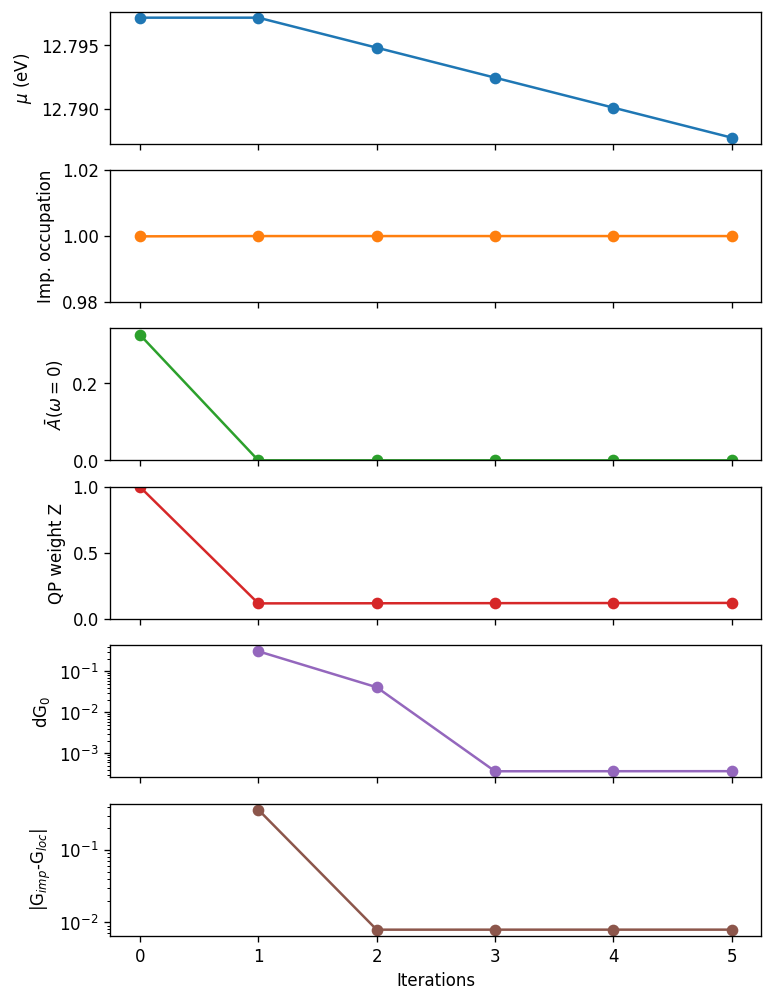

In [5]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
ax[1].set_ylim(0.98,1.02)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(0,)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; compare the self-energy with the analytically continued self-energies for the metallic and the insulating cthyb results. Compare the shapes.

In [6]:
with HDFArchive('b10-U3.6/lco_wannier.h5','r') as h5:
    Sigma_real_freq_cthyb = h5['DMFT_results/last_iter']['Sigma_maxent_0']
    mu = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc = h5['DMFT_results']['last_iter']['DC_pot']


with HDFArchive('b10-U5.0/lco_wannier.h5','r') as h5:
    Sigma_real_freq_cthyb_ins = h5['DMFT_results/last_iter']['Sigma_maxent_0']

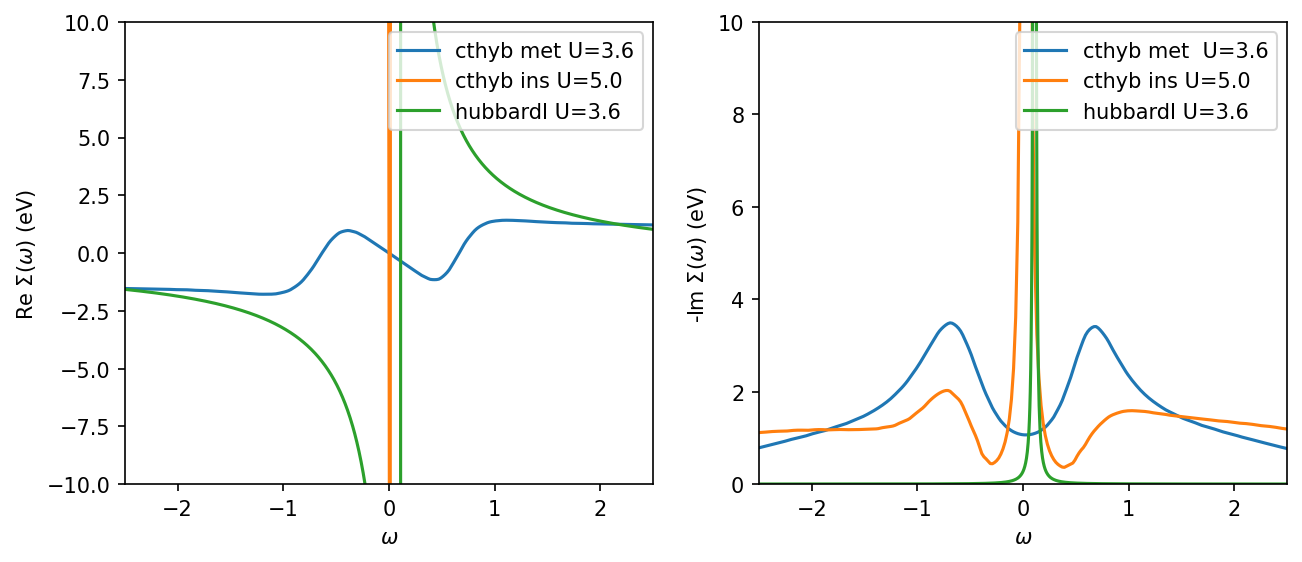

In [7]:
fig, ax = plt.subplots(1,2, sharex=True, dpi=150, figsize=(10,4))

# plot real part of the self-energy and subtract constant offset at 0.0 (Hartree shift)
# Sigma_real_freq['up_0'](0.0) evaluates the self-energy at w=0.0
ax[0].oplot((Sigma_real_freq_cthyb['up_0'] - Sigma_real_freq_cthyb['up_0'](0.0)[0,0]).real, '-', c='C0', label='cthyb met U=3.6')
ax[0].oplot((Sigma_real_freq_cthyb_ins['up_0'] - Sigma_real_freq_cthyb_ins['up_0'](0.0)[0,0]).real, '-', c='C1', label='cthyb ins U=5.0')
ax[0].oplot((Sigma_real_freq_hI['up_0']- Sigma_real_freq_hI['up_0'].data[-1,0,0]).real, '-', c='C2', label='hubbardI U=3.6')
# plot imaginary part of the self-energy
ax[1].oplot(-1*Sigma_real_freq_cthyb['up_0'].imag, '-', c='C0', label='cthyb met  U=3.6')
ax[1].oplot(-1*Sigma_real_freq_cthyb_ins['up_0'].imag, '-', c='C1', label='cthyb ins U=5.0')
ax[1].oplot(-1*Sigma_real_freq_hI['up_0'].imag, '-', c='C2', label='hubbardI U=3.6')

ax[0].set_ylabel(r"Re $\Sigma (\omega)$ (eV)")
ax[1].set_ylabel(r"-Im $\Sigma (\omega)$ (eV)")
ax[0].set_ylim(-10,10)
ax[1].set_ylim(0,10)
ax[-1].set_xlim(-2.5,2.5)
plt.show()

> The HubbardI self-energy has a similar pole structure as the insulating cthyb solution, but even for previously metallic U values. This is always the case for HubbardI, because of the absence of the bath. This means that there is no frequency dependence away from the pole, and no scattering / incoherent features.

Now we can plot and compare the k-dependent spectral function:

In [8]:
try:
    dc_hI[0]['down_0'] = dc_hI[0].pop('down')
    dc_hI[0]['up_0'] = dc_hI[0].pop('up')
except:
    pass

H(R=0):
     12.8956
Setting Sigma from memory
μ=12.7853 eV set for calculating A(k,ω)


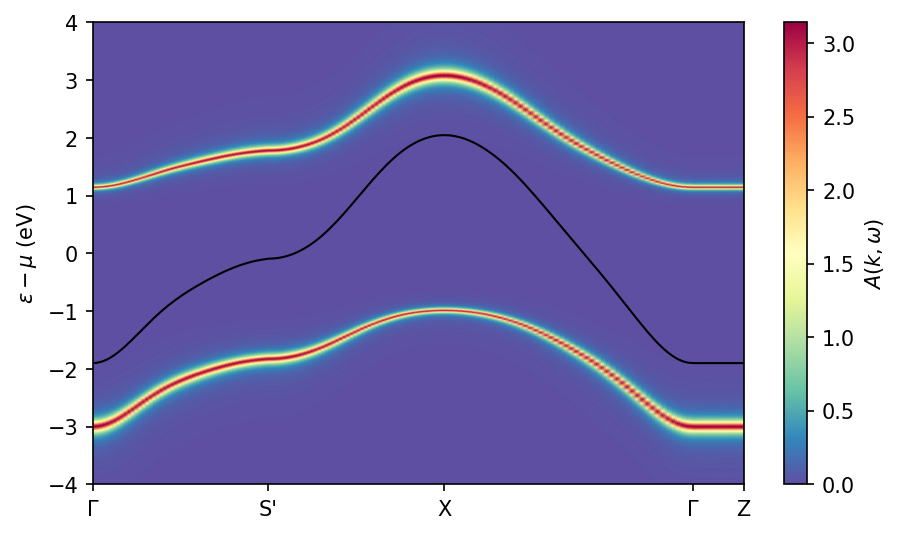

In [9]:
# we have to specify the mesh of the spectral function and pass a new keywargs object sigma_dict
w_mesh = {'window': [-4.0, 4.0], 'n_w': int(501)}
sigma_dict = {'dmft_path': 'b10-U3.6-hubbardI/lco_wannier.h5',
              'it': 'last_iter',
              'spin': 'up_0',
              'block' : 0 ,
              'w_mesh': w_mesh,
              'dc': dc_hI,
              'mu_dmft': mu_hI}

tb_bands, alatt_k_w_path, freq_dict = pcb.get_dmft_bands(with_sigma=Sigma_real_freq_hI, eta=0.1,
                                                         **w90_dict, **tb_dict, **sigma_dict)

fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands, freq_dict, n_orb=w90_dict['n_orb'],
               tb=True, alatt=True, **plot_dict)

<i class="fa fa-gear fa-2x" style="color: #186391"></i>&nbsp; calculate / plot once again the k-integrated spectral function for hubbardI and compare with your previous cthyb result. Plot also the atomic Green's function of the hubbardI solver `G_atomic_w`, which is already on the real frequency axis. Try to answer the following questions:
1) Why do the spectra of the impurity Green's function and the k-integrated lattice Green's function differ?
2) Which features of the spectral function are captured correctly for the same U value?
3) For which kind of systems does the hubbardI approximation deliver reasonable results?

Tip: When summing the lattice Green's functions for the HubbardI self-energy you have to introduce an extra broadening. Add something like `0.4j`.

> 1. The atomic Green's function only shows the excitation energies of the impurity without bath, i.e. multiplet excitations at eps+-U/2 of a single energy level of the atom.
> 2. The incoherent Hubbard peaks are captured correctly for the k-integrated lattice Green's function for a converged number of k-points.
> 3. The HubbardI solver is adequate for atomic-like problems like heavy f-shells with small hybridization.

In [10]:
# triqs function to load a w90 hamiltonian as tight binding object
TB = TB_from_wannier90(seed='lco' ,path='./data/mlwf/')

# calculate epsilon(k) on a given mesh
# since La2CuO4 is mostly 2D, we use a 2D mesh to speed things up
k_dim = 7
k_mesh = TB.get_kmesh(n_k = (k_dim, k_dim, 1))
n_k = np.prod(k_mesh.dims)
e_k = TB.fourier(k_mesh)

# create here first a Gf called G_loc_w for the k summation
G_loc_w_cthyb = Gf(mesh = Sigma_real_freq_cthyb.mesh, target_shape = [1,1])

# now we loop over k-points
for k in e_k.mesh:
    # do the summation for G_loc_w  / the factor 2 is to account for both spin channels, and we divide by the weight 1/n_k
    G_loc_w_cthyb << G_loc_w_cthyb + 2/n_k * inverse(Omega + mu - e_k[k] - (Sigma_real_freq_cthyb['up_0']-dc[0]['up']) )

In [11]:
# create here first a Gf called G_loc_w for the k summation
G_loc_w = Gf(mesh = Sigma_real_freq_hI.mesh, target_shape = [1,1])

# now we loop over k-points
for k in e_k.mesh:
    # do the summation for G_loc_w  / the factor 2 is to account for both spin channels, and we divide by the weight 1/n_k
    G_loc_w << G_loc_w + 2/n_k * inverse(Omega + mu_hI - e_k[k] - (Sigma_real_freq_hI['up_0']-dc[0]['up']) + 0.4j)

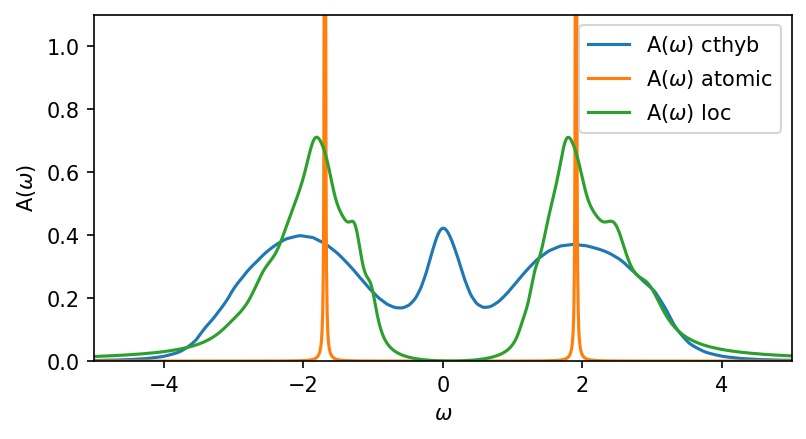

In [12]:
fig, ax = plt.subplots(1,dpi=150,figsize=(6,3))

ax.oplot(-1/np.pi*G_loc_w_cthyb.imag, label=r'A($\omega$) cthyb')

ax.oplot(-1/np.pi*G_atomic_w['up_0'].imag, label=r'A($\omega$) atomic')

ax.oplot(-1/np.pi*G_loc_w.imag, label=r'A($\omega$) loc')

ax.set_ylabel(r'A($\omega$)')
ax.set_xlabel(r'$\omega$')
ax.set_xlim(-5,5)
ax.set_ylim(0,1.1)
ax.legend()
plt.show()

## This concludes the third tutorial. You may now continue with tutorial 04-FermiSee.